## Введение

Задачи проекта:
- Выявить определяющие успешность игры закономерности. 
- Найти потенциально популярные игры и спланировать рекламную кампанию на 2017 год.

Основные шаги:
- загрузка библиотек;
- открытие файлов;
- знакомство с данными;
- выявление аномалий;
- предобработка данных;
- составление портрета пользователя регионов NA, EU, JP;
- проверка двух гипотез (Средние пользовательские рейтинги платформ Xbox One и PC одинаковые; Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные);
- обобщение результатов, формулирование общего вывода.

## Загрузка библиотек

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from scipy import stats as st

## Открытие файла csv, изучение данных 

In [1]:
data = pd.read_csv('/datasets/games.csv') 
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


### Описание данных 

- Name — название игры 
- Platform — платформа 
- Year_of_Release — год выпуска 
- Genre — жанр игры 
- NA_sales — продажи в Северной Америке (миллионы проданных копий) 
- EU_sales — продажи в Европе (миллионы проданных копий) 
- JP_sales — продажи в Японии (миллионы проданных копий) 
- Other_sales — продажи в других странах (миллионы проданных копий) 
- Critic_Score — оценка критиков (максимум 100) 
- User_Score — оценка пользователей (максимум 10) 
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating 
Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает 
им подходящую возрастную категорию. 

In [2]:
data.isna().sum() 

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


### Вывод 

- Название столбцов имеет прописные буквы (необходимо в будущем привести к нижнему регистру) 
- Столбецы `Year_of_Release, Critic_Score ` имеют тип данных float (необходимо заменить на int) 
- Столбец `User_Score` имеет тип данных object (необходимо заменить на float), также в нем найдено значение 'tbd' 
- В пяти столбцах обнаружены пропуски

## Предобработка данных

In [4]:
data = data.rename( 
    columns = { 
        'Name' : 'name', 
        'Platform' : 'platform', 
        'Year_of_Release' : 'year_of_release', 
        'Genre' : 'genre', 
        'NA_sales' : 'na_sales', 
        'EU_sales' : 'eu_sales', 
        'JP_sales' : 'jp_sales', 
        'Other_sales' : 'other_sales', 
        'Critic_Score' : 'critic_score', 
        'User_Score' : 'user_score', 
        'Rating' : 'rating', 
    } 
)

Данные по году и названию игр восстановить средними показателями невозможно, поэтому удаляем их. 

Логически год выпуска не может иметь дробное число, поэтому заменяем тип данных на целочисленный.  

In [5]:
data.dropna(subset = ['year_of_release'], inplace=True)
data.dropna(subset = ['name'], inplace=True)
data['year_of_release'] = data['year_of_release'].astype('int')

In [6]:
data.query('user_score == "tbd"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010,Sports,3.45,2.59,0.0,0.66,NaN,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005,Misc,2.08,1.35,0.0,0.54,61.0,tbd,E10+
520,Zumba Fitness 2,Wii,2011,Sports,1.51,1.03,0.0,0.27,NaN,tbd,T
645,uDraw Studio,Wii,2010,Misc,1.65,0.57,0.0,0.20,71.0,tbd,E
718,Just Dance Kids,Wii,2010,Misc,1.52,0.54,0.0,0.18,NaN,tbd,E
...,...,...,...,...,...,...,...,...,...,...,...
16695,Planet Monsters,GBA,2001,Action,0.01,0.00,0.0,0.00,67.0,tbd,E
16697,Bust-A-Move 3000,GC,2003,Puzzle,0.01,0.00,0.0,0.00,53.0,tbd,E
16698,Mega Brain Boost,DS,2008,Puzzle,0.01,0.00,0.0,0.00,48.0,tbd,E
16704,Plushees,DS,2008,Simulation,0.01,0.00,0.0,0.00,NaN,tbd,E


Вероятно значение 'tbd' в столбце `user_score` появляется, когда количество оценок пользователей не достаточно, чтобы вычислить объективную пользовательскую оценку. Так как это значение имеет тип object и мешает нам работать с данными, заменим его на NaN.

Добавляем столбец `all_sales` с суммарными продажами во всех регионах.

In [7]:
data = data.replace('tbd', 'NaN')
data['all_sales'] = data[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)

In [8]:
data.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         6605
rating             6676
all_sales             0
dtype: int64

In [9]:
data.query('critic_score == "NaN"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales


Так как в данных `critic_score` присутствуют только целые числа, заменяем их тип на Int64, а в `user_score` на Float64.

In [10]:
data['critic_score'] = data['critic_score'].astype('Int64')
#FIXIT
data['user_score'] = data['user_score'].astype('float64')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   Int64  
 9   user_score       7463 non-null   float64
 10  rating           9768 non-null   object 
 11  all_sales        16444 non-null  float64
dtypes: Int64(1), float64(6), int64(1), object(4)
memory usage: 1.6+ MB


### Вывод

- Данные по году и названию игр восстановить средними показателями невозможно, поэтому они были удалены. 
- Логически год выпуска не может иметь дробное число, поэтому тип данных заменен на целочисленный.  
- В столбце `user_score` 'tbd' имеет тип object и мешает нам работать с данными. Значение было заменено на NaN, а весь столбец переведен в тип данных Float64.
- Так как в данных `critic_score` присутствуют только целые числа, тип данных столбца был заменен на Int64.
- Добавлен столбец `all_sales` с суммарными продажами во всех регионах.
- Так как большинство отсутствующих данных в `critic_score, user_score` и `rating` взаимосвязаны между собой, а корреляция между количеством проданных игр и их рейтингом, а также оценками слабая, восстановить их без потери качества данных невозможно.

## Исследовательский анализ данных
### Год выпуска игр

In [11]:
data_year = data.pivot_table(index='year_of_release',values='name',aggfunc='count')
data_year

,name
year_of_release,
1980,9
1981,46
1982,36
1983,17
1984,14
1985,14
1986,21
1987,16
1988,15


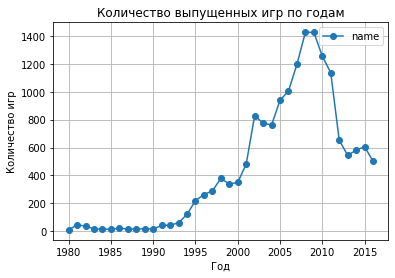

In [12]:
plot = data_year.plot(style='o-', grid=True, title='Количество выпущенных игр по годам');
plot.set_xlabel("Год") 
plot.set_ylabel("Количество игр"); 

С 2000 года по 2008 наблюдался значительный рос количества выпусков компьютерных игр (с 350 до 1427 игр в год), с 2009 по 2016 год наблюдается спад количества выпусков компьютерных игр (с 1426 до 502 игр в год). Пик по выпускам игр: 2008-2009 годы.

Это может быть связано с улучшением их качества с 2009 года, и как следствие, увеличением времени их разработки (что напрямую влияет на уменьшение их количества). В таком случае качество должно коррелировать с оценками пользователей и критиков, а также количеством продаж. Подтвердить или опровергнуть эту гипотезу мы сможем изучив эти показатели.

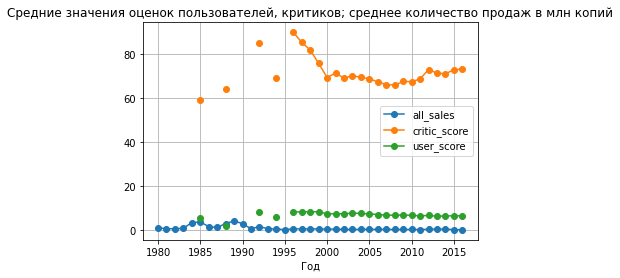

In [13]:
data_year_score = data.pivot_table(index='year_of_release',values=['critic_score', 'user_score', 'all_sales'],aggfunc='mean')
plot1 = data_year_score.plot(style='o-', grid=True, 
                     title='Средние значения оценок пользователей, критиков; среднее количество продаж в млн копий')
plot1.set_xlabel("Год");

Видимо это предположение было ошибочным.

Однако по данному графику видно, что значительное число данных о продажах и рейтингах отсутствует до 1996 года. Значит данные за этот период лучше не учитывать в дальнейшем анализе.

### Продажи по платформам

In [14]:
data_platform = data.pivot_table(index='platform',values='all_sales',aggfunc='sum')
data_platform.query('all_sales > 200').sort_values(by='all_sales', ascending=False)

,all_sales
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.78
PS,727.58
PS4,314.14
GBA,312.88
PSP,289.53


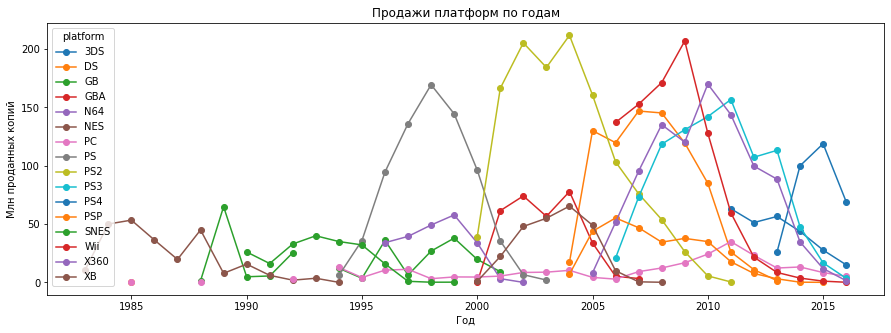

In [15]:
popular_platform = ['SNES', 'N64','NES','XB','GB','PC','3DS','PSP','GBA','PS4', 'PS', 'DS','Wii', 'PS3', 'X360', 'PS2']
data_platform_year = data.query('platform in @popular_platform').pivot_table(
    index='year_of_release', columns='platform',values='all_sales',aggfunc='sum')
plot2 = data_platform_year.plot(figsize=(15,5),style='o-', title = 'Продажи платформ по годам');
plot2.set_xlabel("Год")
plot2.set_ylabel("Млн проданных копий");

In [16]:
data_platform_year.count().mean()

10.875

In [17]:
data.pivot_table(
    index='year_of_release', columns='platform',values='all_sales',aggfunc='sum').count().mean()

7.67741935483871

Пять платформ с наибольшим количеством проданных копий с 1983 по 2016 гг.: 
- PS2 -	1233.56 млн (2000-2011 гг.)
- X360 - 961.24 млн (2005-2016 гг.)
- PS3 -	931.34 млн (2006-2016 гг.)
- Wii -	891.18 млн (2006-2016 гг.)
- DS -	802.78 млн (2004-2013 гг.)

Средний срок жизни платформы с общими продажами более 200 миллионов копий - почти 11 лет, средний срок жизни всех анализируемых платформ - 7.67 лет.

Так как ситуация на рынке компьютерных игр менятся достаточно быстро, то в качестве актуального периода можно взять половину среднего срока жизни платформы (4 года), так как условно половина срока жизни платформы занимает рост, а другая половина - спад. Для дальнейшего анализа и построения прогноза на 2017 год будут использоваться данные с 2012 по 2016 гг.

In [18]:
data_relevant = data.query('year_of_release > 2011')
data_relevant_pivot_table = data_relevant.pivot_table(index='platform',values='all_sales',aggfunc='sum')
data_relevant_pivot_table.sort_values(by='all_sales', ascending=False)

,all_sales
platform,
PS4,314.14
PS3,288.79
X360,236.54
3DS,194.61
XOne,159.32
WiiU,82.19
PC,62.65
PSV,49.18
Wii,35.37


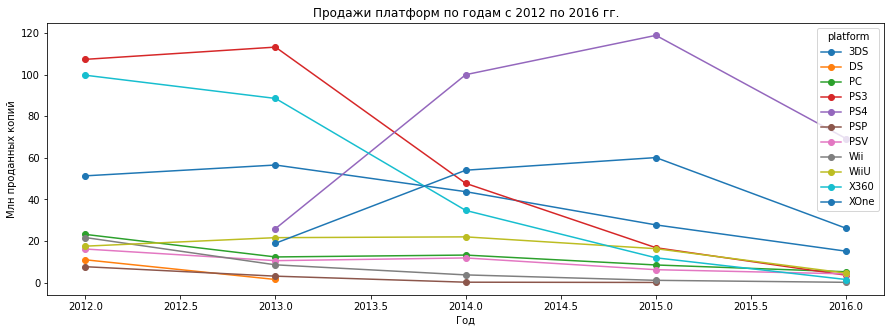

In [19]:
relevant_platform = data_relevant.pivot_table(
    index='year_of_release', columns='platform',values='all_sales',aggfunc='sum')
plot3 = relevant_platform.plot(figsize=(15,5),style='o-',title = 'Продажи платформ по годам c 2012 по 2016 гг.');
plot3.set_xlabel("Год")
plot3.set_ylabel("Млн проданных копий");

In [20]:
relevant_platform

platform,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,,,
2012,51.36,11.01,23.22,107.36,NaN,7.69,16.19,21.71,17.56,99.74,NaN
2013,56.57,1.54,12.38,113.25,25.99,3.14,10.59,8.59,21.65,88.58,18.96
2014,43.76,NaN,13.28,47.76,100.00,0.24,11.90,3.75,22.03,34.74,54.07
2015,27.78,NaN,8.52,16.82,118.90,0.12,6.25,1.14,16.35,11.96,60.14
2016,15.14,NaN,5.25,3.60,69.25,NaN,4.25,0.18,4.60,1.52,26.15


Пять платформ с наибольшим количеством проданных копий с 2012 по 2016 гг.: 
- PS4 -	314.14 млн (росла до 2015 г.)
- PS3 - 288.79 млн (на спаде с 2009 г.)
- X360 - 236.54 млн (на спаде с 2013 г.)
- 3DS -	194.61 млн (на спаде с года открытия продаж, с 2011 г.)
- XOne - 159.32 млн (росла до 2015 г.)

Предположительно в фазе роста продаж находятся две платформы:
- XOne
- PS4

Text(0, 0.5, 'Количество проданных копий в млн')

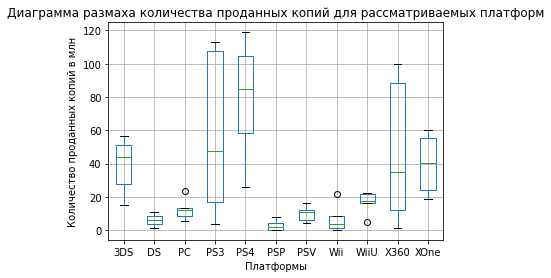

In [21]:
warnings.filterwarnings('ignore')
relevant_platform.boxplot();
plt.title('Диаграмма размаха количества проданных копий для рассматриваемых платформ')
plt.xlabel('Платформы')
plt.ylabel('Количество проданных копий в млн')

Самый высокий уровень медианы и интерквартального размаха по количеству проданных копий наблюдается у платформы `PS4`. Предположительно на момент построения прогноза на 2017 год это будет самая потенциально прибыльная платформа.

Другие потенциально прибыльные платформы по этим показателям:
- PS3
- 3DS
- XOne
- X360

### Отзывы пользователей и критиков платформы PS4

-0.031957110204556376

Text(0, 0.5, 'Количество проданных копий в млн')

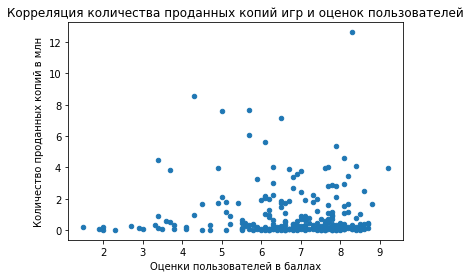

In [22]:
data_relevant_ps4 = data_relevant.query('platform == "PS4"')
display(data_relevant_ps4['user_score'].corr(data_relevant_ps4['all_sales']))
data_relevant_ps4.plot(x='user_score', y='all_sales', kind='scatter');
plt.title('Корреляция количества проданных копий игр и оценок пользователей')
plt.xlabel('Оценки пользователей в баллах')
plt.ylabel('Количество проданных копий в млн')

Корреляция между отзывами пользователей и количеством проданных копий платформы PS4 отсутствует.

0.40656790206178095


Text(0, 0.5, 'Количество проданных копий в млн')

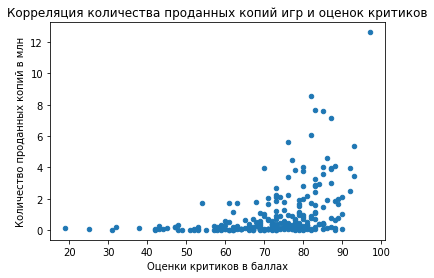

In [23]:
print(data_relevant_ps4['critic_score'].astype('float64').corr(data_relevant_ps4['all_sales']))
data_relevant_ps4.plot(x='critic_score', y='all_sales', kind='scatter');
plt.title('Корреляция количества проданных копий игр и оценок критиков')
plt.xlabel('Оценки критиков в баллах')
plt.ylabel('Количество проданных копий в млн')

Между отзывами критиков и количеством проданных копий платформы PS4 наблюдается слабая положительная корреляция.

0.5576539782764632


Text(0, 0.5, 'Оценки пользователей в баллах')

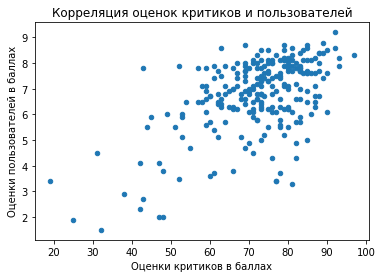

In [24]:
print(data_relevant_ps4['critic_score'].astype('float64').corr(data_relevant_ps4['user_score']))
data_relevant_ps4.plot(x='critic_score', y='user_score', kind='scatter');
plt.title('Корреляция оценок критиков и пользователей')
plt.xlabel('Оценки критиков в баллах')
plt.ylabel('Оценки пользователей в баллах')

Между отзывами критиков и отзывами пользователей платформы PS4 наблюдается положительная корреляция.

### Отзывы пользователей и критиков всех платформ

0.0044288176754932575

Text(0, 0.5, 'Количество проданных копий в млн')

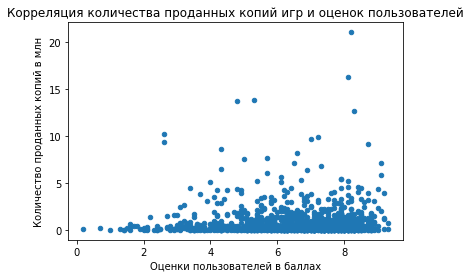

In [25]:
display(data_relevant['user_score'].corr(data_relevant['all_sales']))
data_relevant.plot(x='user_score', y='all_sales', kind='scatter');
plt.title('Корреляция количества проданных копий игр и оценок пользователей')
plt.xlabel('Оценки пользователей в баллах')
plt.ylabel('Количество проданных копий в млн')

Корреляция между отзывами пользователей и количеством проданных копий отсутствует.

0.3081967459207781


Text(0, 0.5, 'Количество проданных копий в млн')

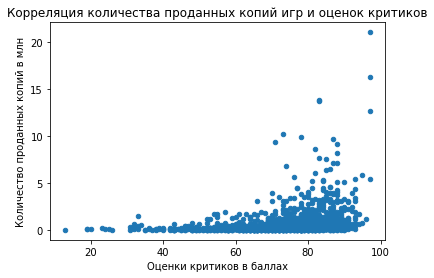

In [26]:
print(data_relevant['critic_score'].astype('float64').corr(data_relevant['all_sales']))
data_relevant.plot(x='critic_score', y='all_sales', kind='scatter');
plt.title('Корреляция количества проданных копий игр и оценок критиков')
plt.xlabel('Оценки критиков в баллах')
plt.ylabel('Количество проданных копий в млн')

Между отзывами критиков и количеством проданных копий наблюдается слабая положительная корреляция.

0.5177272095232911


Text(0, 0.5, 'Оценки пользователей в баллах')

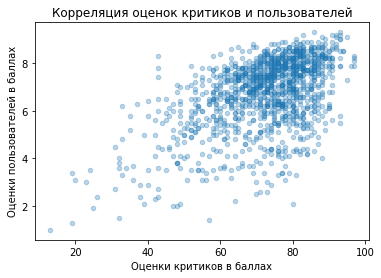

In [27]:
print(data_relevant['critic_score'].astype('float64').corr(data_relevant['user_score']))
data_relevant.plot(x='critic_score', y='user_score', kind='scatter', alpha=0.3);
plt.title('Корреляция оценок критиков и пользователей')
plt.xlabel('Оценки критиков в баллах')
plt.ylabel('Оценки пользователей в баллах')

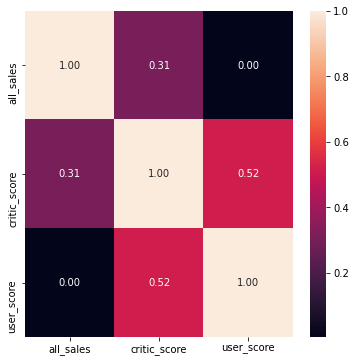

In [28]:
plt.figure(figsize=(6,6))
sns.heatmap(data_relevant[['all_sales', 'critic_score', 'user_score']].corr(), annot=True, fmt='.2f');  

Между отзывами критиков и отзывами пользователей наблюдается положительная корреляция.

Выводы сделанные по популярной платформе PS4 характерны и для других рассматриваемых платформ.

### Распределение по жанрам

In [29]:
data_relevant_genre = data_relevant.pivot_table(index='genre',values='all_sales',aggfunc=['sum','count'])
data_relevant_genre['mean_sales']=data_relevant_genre['sum']['all_sales'] / data_relevant_genre['count']['all_sales']
data_relevant_genre.sort_values(by='mean_sales', ascending=False)

,sum,count,mean_sales
,all_sales,all_sales,
genre,,,
Shooter,304.73,235,1.296723
Platform,61.00,85,0.717647
Sports,181.07,268,0.675634
Role-Playing,192.80,370,0.521081
Racing,53.50,115,0.465217
Misc,85.04,192,0.442917
Simulation,35.12,80,0.439000
Action,441.12,1031,0.427856


In [30]:
print('Корреляция между количеством продаж внутри одного жанра и количеством игр этого жанра:',
      data_relevant_genre['sum']['all_sales'].corr(data_relevant_genre['count']['all_sales']))
print('Корреляция между средним количеством продаж этого жанра и количеством игр этого жанра:',
      data_relevant_genre['mean_sales'].corr(data_relevant_genre['count']['all_sales']))
print('Корреляция между количеством продаж внутри одного жанра и средним количеством продаж этого жанра:',
      data_relevant_genre['sum']['all_sales'].corr(data_relevant_genre['mean_sales']))

Корреляция между количеством продаж внутри одного жанра и количеством игр этого жанра: 0.8538646336191406
Корреляция между средним количеством продаж этого жанра и количеством игр этого жанра: 0.041019508827039086
Корреляция между количеством продаж внутри одного жанра и средним количеством продаж этого жанра: 0.5256908015039641


Самое большое количество проданных копий принадлежат жанрам:
- Action (441.12 млн копий)
- Shooter (304.73 млн копий)
- Role-Playing (192.80 млн копий)
- Sports (181.07 млн копий)

Однако, если рассматривать жанр Action, то количество произведенных игр в 3-4 раза больше, чем у других жанров, являющихся лидерами продаж. Это значит, что среди них есть как популярные, так и имеющие очень низкий спрос.

Самые высокие средние продажи принадлежат жанрам:
- Shooter (куплено 1.29 млн копий каждой игры этого жанра)
- Platform (0.71 млн копий)
- Sports (0.67 млн копий)
- Role-Playing (0.52 млн копий)

Количество продаж внутри одного жанра и количество игр этого жанра коррелируют между собой.

### Вывод

С 2000 года по 2008 наблюдался значительный рос количества выпусков компьютерных игр (с 350 до 1427 игр в год), с 2009 по 2016 год наблюдается спад количества выпусков компьютерных игр (с 1426 до 502 игр в год). Пик по выпускам игр: 2008-2009 годы.

Средний срок жизни платформы с общими продажами более 200 миллионов копий - почти 11 лет, средний срок жизни всех анализируемых платформ - 7.67 лет.

Так как ситуация на рынке компьютерных игр менятся достаточно быстро, то в качестве актуального периода была принята половина среднего срока жизни платформы (4 года). Для анализа и построения прогноз на 2017 год были использованы данные с 2012 по 2016 гг.

Пять платформ с наибольшим количеством проданных копий с 2012 по 2016 гг.: 
- PS4 -	314.14 млн (росла до 2015 г.)
- PS3 - 288.79 млн (на спаде с 2009 г.)
- X360 - 236.54 млн (на спаде с 2013 г.)
- 3DS -	194.61 млн (на спаде с года открытия продаж, с 2011 г.)
- XOne - 159.32 млн (росла до 2015 г.)

Предположительно в фазе роста продаж находятся две платформы:
- XOne
- PS4

Самый высокий уровень медианы и интерквартального размаха по количеству проданных копий наблюдается у платформы `PS4`. Предположительно на момент построения прогноза на 2017 год это будет самая потенциально прибыльная платформа.

Корреляция между отзывами пользователей и количеством проданных копий отсутствует. Между отзывами критиков и количеством проданных копий наблюдается слабая положительная корреляция. Между отзывами критиков и отзывами пользователей наблюдается положительная корреляция.

Самые прибыльные жанры игр:
- Action
- Shooter
- Role-Playing
- Sports
- Platform

Однако, если рассматривать жанр Action, то количество произведенных игр в 3-4 раза больше, чем у других жанров, являющихся лидерами продаж. Это значит, что среди них есть как популярные, так и имеющие очень низкий спрос.

Количество продаж внутри одного жанра и количество игр этого жанра коррелируют между собой.

## Портрет пользователя регионов NA, EU, JP

### Регион NA

In [31]:
data_relevant.pivot_table(index='platform',values='na_sales', aggfunc='sum').sort_values(
    by='na_sales',ascending=False).head(5)

,na_sales
platform,
X360,140.05
PS4,108.74
PS3,103.38
XOne,93.12
3DS,55.31


In [32]:
data_relevant.pivot_table(index='genre',values='na_sales', aggfunc='sum').sort_values(
    by='na_sales',ascending=False).head(5)

,na_sales
genre,
Action,177.84
Shooter,144.77
Sports,81.53
Role-Playing,64.00
Misc,38.19


In [33]:
data_relevant.pivot_table(index='rating',values='na_sales', aggfunc='sum').sort_values(by='na_sales',ascending=False)

,na_sales
rating,
M,231.57
E,114.37
E10+,75.70
T,66.02


В регионе NA большее количество продаж у платформ:
- X360
- PS4
- PS3
- XOne
- 3DS

Большее количество продаж у жанров:
- Action
- Shooter
- Sports
- Role-Playing
- Misc

Из рейтинга ESRB самый популярный в регионе NA - М.

### Регион EU

In [34]:
data_relevant.pivot_table(index='platform',values='eu_sales', aggfunc='sum').sort_values(
    by='eu_sales',ascending=False).head(5)

,eu_sales
platform,
PS4,141.09
PS3,106.86
X360,74.52
XOne,51.59
3DS,42.64


In [35]:
data_relevant.pivot_table(index='genre',values='eu_sales', aggfunc='sum').sort_values(
    by='eu_sales',ascending=False).head(5)

,eu_sales
genre,
Action,159.34
Shooter,113.47
Sports,69.09
Role-Playing,48.53
Racing,27.29


In [36]:
data_relevant.pivot_table(index='rating',values='eu_sales', aggfunc='sum').sort_values(by='eu_sales',ascending=False)

,eu_sales
rating,
M,193.96
E,113.03
E10+,55.37
T,52.96


В регионе EU большее количество продаж у платформ:
- PS4
- PS3
- X360
- XOne
- 3DS

Большее количество продаж у жанров:
- Action
- Shooter
- Sports
- Role-Playing
- Racing

Из рейтинга ESRB самый популярный в регионе EU - М.

### Регион JP

In [37]:
data_relevant.pivot_table(index='platform',values='jp_sales', aggfunc='sum').sort_values(
    by='jp_sales',ascending=False).head(5)

,jp_sales
platform,
3DS,87.79
PS3,35.29
PSV,21.04
PS4,15.96
WiiU,13.01


In [38]:
data_relevant.pivot_table(index='genre',values='jp_sales', aggfunc='sum').sort_values(by='jp_sales',ascending=False).head(5)

,jp_sales
genre,
Role-Playing,65.44
Action,52.80
Misc,12.86
Simulation,10.41
Fighting,9.44


In [39]:
data_relevant.pivot_table(index='rating',values='jp_sales', aggfunc='sum').sort_values(by='jp_sales',ascending=False)

,jp_sales
rating,
E,28.33
T,26.02
M,21.20
E10+,8.19


В регионе JP большее количество продаж у платформ:
- 3DS
- PS3
- PSV
- PS4
- WiiU

Большее количество продаж у жанров:
- Role-Playing
- Action
- Misc
- Simulation
- Fighting

Из рейтинга ESRB самый популярный в регионе JP - E, но разница с Т и М не велика.

### Объединение портретов пользователя

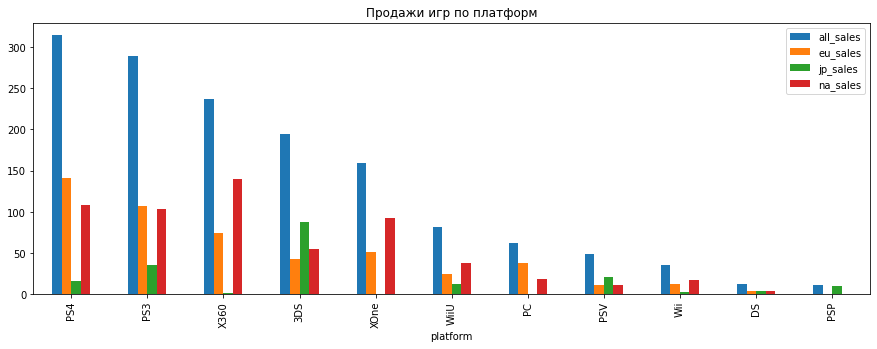

In [40]:
data1 = data_relevant.pivot_table(index='platform',values=['na_sales','eu_sales','jp_sales','all_sales'], 
                                  aggfunc='sum').sort_values(by='all_sales',ascending=False)
data1.plot.bar(title='Продажи игр по платформ',figsize=(15,5));

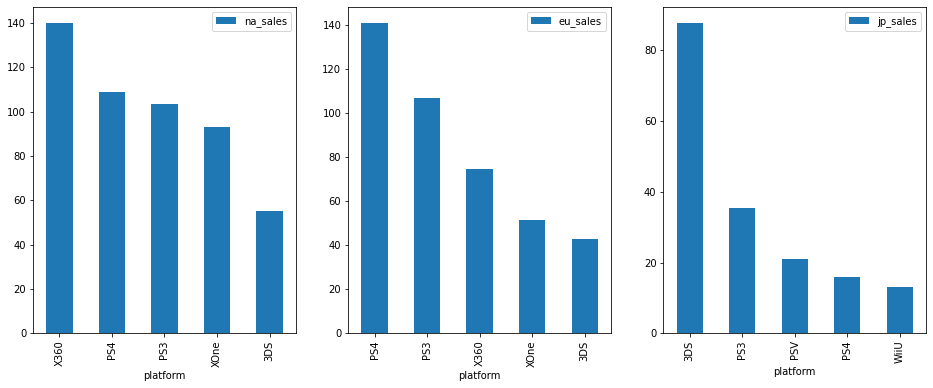

In [41]:
fig, axs = plt.subplots(1, 3, figsize=(16,6))
for col, ax in  zip(['na_sales', 'eu_sales',  'jp_sales'], axs):
    data_relevant.pivot_table(index='platform',values=col, aggfunc='sum')\
                 .sort_values(by=col,ascending=False)\
                 .head()\
                 .plot(kind='bar', ax=ax)

Платформы PS4, PS3, 3DS популярны в трех представленных регионах. В JP более популярна - 3DS, а в NA и EU - две остальные.

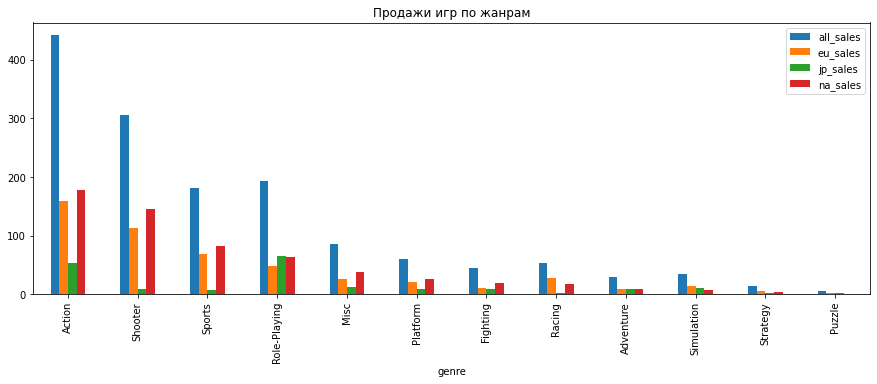

In [42]:
data2 = data_relevant.pivot_table(index='genre',values=['na_sales','eu_sales','jp_sales','all_sales'],
                                  aggfunc='sum').sort_values(by='na_sales',ascending=False)
data2.plot.bar(title='Продажи игр по жанрам',figsize=(15,5));

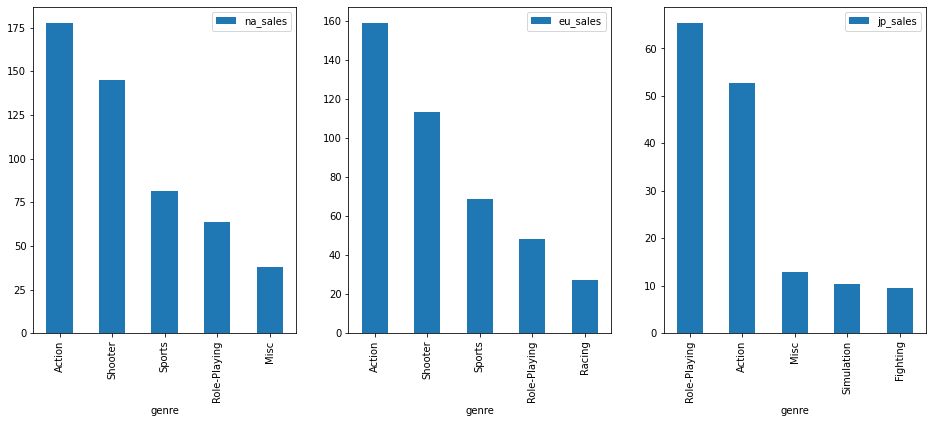

In [43]:
fig, axs = plt.subplots(1, 3, figsize=(16,6))
for col, ax in  zip(['na_sales', 'eu_sales',  'jp_sales'], axs):
    data_relevant.pivot_table(index='genre',values=col, aggfunc='sum')\
                 .sort_values(by=col,ascending=False)\
                 .head()\
                 .plot(kind='bar', ax=ax)

Жанры Role-Playing и Action популярны в трех представленных регионах. В JP более популярен Role-Playing, а в NA и EU - Action.

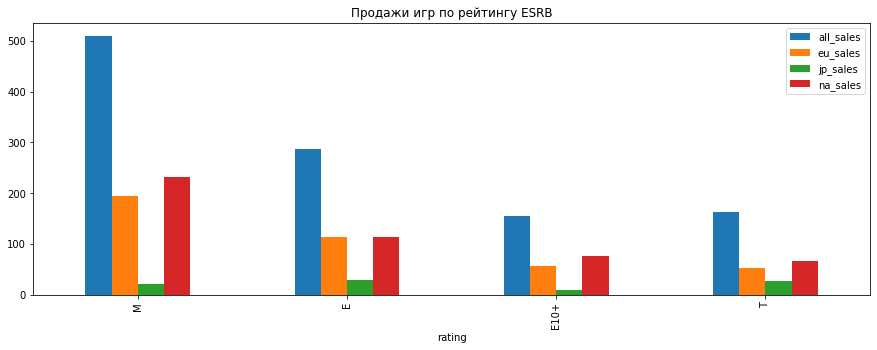

In [44]:
data3 = data_relevant.pivot_table(index='rating',values=['na_sales','eu_sales','jp_sales','all_sales'],
                                  aggfunc='sum').sort_values(by='na_sales',ascending=False)
data3.plot.bar(title='Продажи игр по рейтингу ESRB',figsize=(15,5));

Продажи игр по рейтингу ESRB распределены по регионам достаточно равномерно.

### Вывод

В регионе NA большее количество продаж у платформ: X360, PS4, PS3, XOne, 3DS.
Большее количество продаж у жанров: Action, Shooter, Sports, Role-Playing, Misc.
Из рейтинга ESRB самый популярный в регионе NA - М.

В регионе EU большее количество продаж у платформ: PS4, PS3, X360, XOne, 3DS.
Большее количество продаж у жанров: Action, Shooter, Sports, Role-Playing, Racing.
Из рейтинга ESRB самый популярный в регионе EU - М.

В регионе JP большее количество продаж у платформ: 3DS, PS3, PSV, PS4, WiiU.
Большее количество продаж у жанров: Role-Playing, Action, Misc, Simulation, Fighting.
Из рейтинга ESRB самый популярный в регионе JP - E, но разница с Т и М не велика.

Платформы PS4, PS3, 3DS популярны в трех представленных регионах. В JP более популярна - 3DS, а в NA и EU - две остальные.

Жанры Role-Playing и Action популярны в трех представленных регионах. В JP более популярен Role-Playing, а в NA и EU - Action.

При создании портретов пользователей стало видно, что регионы NA и EU занимают большую часть рынка и имеют схожие предпочтения, а JP не только имеет меньшее количество продаж, но и достаточно обособлен от первых двух по предпочтениям.

Продажи игр по рейтингу ESRB распределены по регионам достаточно равномерно.

## Проверка гипотез

### Гипотеза "Средние пользовательские рейтинги платформ Xbox One и PC одинаковые"

Формулирование гипотез:

- Нулевая гипотеза: Средний пользовательский рейтинг платформы Xbox One равен среднему пользовательскому рейтингу платформы PC.

- Альтернативная гипотеза: Средний пользовательский рейтинг платформы Xbox One не равен среднему пользовательскому рейтингу платформы PC.

Применяем t-тест, так как генеральные совокупности не зависят друг от друга и размер выборки достаточно большой.

In [45]:
data_xone = data_relevant[data_relevant['platform'] == 'XOne'].dropna()
data_pc = data_relevant[data_relevant['platform'] == 'PC'].dropna()

sample_1 = data_xone['user_score']
sample_2 = data_pc['user_score']


alpha = .05

results = st.ttest_ind(
    sample_1, 
    sample_2,
    equal_var = False)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.41668656393474524
Не получилось отвергнуть нулевую гипотезу


In [46]:
print('Среднее значение ср. польз. рейтинга XOne:', data_xone['user_score'].mean())
print('Стандартное отклонение ср. польз. рейтинга XOne:', data_xone['user_score'].std())
print('Дисперсия ср. польз. рейтинга XOne:', data_xone['user_score'].var())
print()
print('Среднее значение ср. польз. рейтинга PC:', data_pc['user_score'].mean())
print('Стандартное отклонение ср. польз. рейтинга PC:', data_pc['user_score'].std())
print('Дисперсия ср. польз. рейтинга PC:', data_pc['user_score'].var())

Среднее значение ср. польз. рейтинга XOne: 6.49308176100629
Стандартное отклонение ср. польз. рейтинга XOne: 1.3384347317846739
Дисперсия ср. польз. рейтинга XOne: 1.7914075312475122

Среднее значение ср. польз. рейтинга PC: 6.358045977011493
Стандартное отклонение ср. польз. рейтинга PC: 1.684412962065903
Дисперсия ср. польз. рейтинга PC: 2.837247026775629


Полученное значение p-value говорит о том, что вероятность получить равные средние рейтинги случайно - 42%. 
Рассчитав средние пользовательские оценки по платформам, мы видим, что они действительно имеют близкие значения.

### Гипотеза "Средние пользовательские рейтинги жанров Action и Sports разные"

Формулирование гипотез:

- Нулевая гипотеза: Средний пользовательский рейтинг жанра Action равен среднему пользовательскому рейтингу жанра Sports.

- Альтернативная гипотеза: Средний пользовательский рейтинг жанра Action не равен среднему пользовательскому рейтингу жанра Sports

Применяем t-тест, так как генеральные совокупности не зависят друг от друга и размер выборки достаточно большой.

In [47]:
data_action = data_relevant[data_relevant['genre'] == 'Action'].dropna()
data_sports = data_relevant[data_relevant['genre'] == 'Sports'].dropna()

sample_1 = data_action['user_score']
sample_2 = data_sports['user_score']


alpha = .05

results = st.ttest_ind(
    sample_1, 
    sample_2,
    equal_var = False)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  4.778145125344677e-13
Отвергаем нулевую гипотезу


In [48]:
print('Среднее значение ср. польз. рейтинга Action:', data_action['user_score'].mean())
print('Стандартное отклонение ср. польз. рейтинга Action:', data_action['user_score'].std())
print('Дисперсия ср. польз. рейтинга Action:', data_action['user_score'].var())
print()
print('Среднее значение ср. польз. рейтинга Sports:', data_sports['user_score'].mean())
print('Стандартное отклонение ср. польз. рейтинга Sports:', data_sports['user_score'].std())
print('Дисперсия ср. польз. рейтинга Sports:', data_sports['user_score'].var())

Среднее значение ср. польз. рейтинга Action: 6.874881516587677
Стандартное отклонение ср. польз. рейтинга Action: 1.3259816818522308
Дисперсия ср. польз. рейтинга Action: 1.7582274206076707

Среднее значение ср. польз. рейтинга Sports: 5.8161764705882355
Стандартное отклонение ср. польз. рейтинга Sports: 1.415638611983497
Дисперсия ср. польз. рейтинга Sports: 2.004032679738562


Полученное значение p-value говорит о том, что вероятность получить для двух жанров одинаковый пользовательский рейтинг очень мала, нулевую гипотезу можно отвергнуть.

### Вывод

Для гипотезы "Средние пользовательские рейтинги платформ Xbox One и PC одинаковые" была сформулирована нулевая гипотеза: Средний пользовательский рейтинг платформы Xbox One равен среднему пользовательскому рейтингу платформы PC. Ее отвергнуть не получилось, так как полученное значение p-value говорит о том, что вероятность получить равные средние рейтинги случайно - 42%. 
Рассчитав средние пользовательские оценки по платформам, мы видим, что они действительно имеют близкие значения.

Для гипотезы "Средние пользовательские рейтинги жанров Action и Sports разные" была сформулирована нулевая гипотеза: Средний пользовательский рейтинг жанра Action равен среднему пользовательскому рейтингу жанра Sports. Она была отвергнута, так как в ходе t-теста было получено очень маленькое p-значение (9.491264299467366e-15). Гипотеза "Средние пользовательские рейтинги жанров Action и Sports разные" была подтверждена.

## Общий вывод

С 2000 года по 2008 наблюдался значительный рос количества выпусков компьютерных игр (с 350 до 1427 игр в год), с 2009 по 2016 год наблюдается спад количества выпусков компьютерных игр (с 1426 до 502 игр в год). Пик по выпускам игр: 2008-2009 годы.

Так как ситуация на рынке компьютерных игр менятся достаточно быстро, то в качестве актуального периода была принята половина среднего срока жизни платформы (4 года). Для анализа и построения прогноза на 2017 год были использованы данные с 2012 по 2016 гг.

Пять платформ с наибольшим количеством проданных копий с 2012 по 2016 гг.: 
- PS4 -	314.14 млн (росла до 2015 г.)
- PS3 - 288.79 млн (на спаде с 2009 г.)
- X360 - 236.54 млн (на спаде с 2013 г.)
- 3DS -	194.61 млн (на спаде с года открытия продаж, с 2011 г.)
- XOne - 159.32 млн (росла до 2015 г.)

Предположительно в фазе роста продаж находятся две платформы:
- XOne
- PS4

Самый высокий уровень медианы и интерквартального размаха по количеству проданных копий наблюдается у платформы PS4. 

Предположительно на момент построения прогноза на 2017 год это будет самая потенциально прибыльная платформа.

Самые прибыльные жанры игр:
- Action
- Shooter
- Role-Playing
- Sports
- Platform

Однако, если рассматривать жанр Action, то количество произведенных игр в 3-4 раза больше, чем у других жанров, являющихся лидерами продаж. Это значит, что среди них есть как популярные, так и имеющие очень низкий спрос.

В регионе NA большее количество продаж у платформ: X360, PS4, PS3, XOne, 3DS.
Большее количество продаж у жанров: Action, Shooter, Sports, Role-Playing, Misc.
Из рейтинга ESRB самый популярный в регионе NA - М.

В регионе EU большее количество продаж у платформ: PS4, PS3, X360, XOne, 3DS.
Большее количество продаж у жанров: Action, Shooter, Sports, Role-Playing, Racing.
Из рейтинга ESRB самый популярный в регионе EU - М.

В регионе JP большее количество продаж у платформ: 3DS, PS3, PSV, PS4, WiiU.
Большее количество продаж у жанров: Role-Playing, Action, Misc, Simulation, Fighting.
Из рейтинга ESRB самый популярный в регионе JP - E, но разница с Т и М не велика.

Платформы PS4, PS3, 3DS популярны в трех представленных регионах. В JP более популярна - 3DS, а в NA и EU - две остальные.

Жанры Role-Playing и Action популярны в трех представленных регионах. В JP более популярен Role-Playing, а в NA и EU - Action.

При создании портретов пользователей стало видно, что регионы NA и EU занимают большую часть рынка и имеют схожие предпочтения, а JP не только имеет меньшее количество продаж, но и достаточно обособлен от первых двух по предпочтениям.

Продажи игр по рейтингу ESRB распределены по регионам достаточно равномерно.